In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import time

In [2]:
def scroll(driver, timeout, loops):
    scroll_pause_time = timeout

    last_height = driver.execute_script("return document.body.scrollHeight")
    num = 0
    
    while True and num < loops:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        num = num + 1
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

In [3]:
url = 'https://www.vivino.com/explore?e=eJwdijsOgCAQBW_zaqDfzo4jGGPWFQmJgAH83V5iM1PMxEIaMSRSiPyQ0UpBXhospMPi6NlvdHEJrvGOvFDhFpKvs-QzNWRaXRXcbZz6-st8itQcHw%3D%3D'
product_names = []
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True
browser = webdriver.Firefox(options=options)
options.add_argument("start-maximized")
options.add_argument('disable-infobars')

def scrape():
    browser.get(url)
    loops = 1
    timeout = 5
    scroll(browser, timeout, loops)

    titles = browser.find_elements_by_class_name('vintageTitle__wine--U7t9G')
    prices = browser.find_elements_by_xpath("(//*[contains(@class, 'addToCartButton__price')])")
    ratings = browser.find_elements_by_class_name('vivinoRating__averageValue--3Navj')
    countries = browser.find_elements_by_xpath('//a[contains(@href, "/explore?country_code")]')
    
    for title, price, rating, country in zip(titles, prices, ratings, countries):
        with open('vinDataLarge.csv', 'a', encoding='UTF8') as f:
            writer = csv.writer(f)
            date = 9999
            line = re.findall(r'\d+', title.text)
        
            if(len(line)>0):
                for l in line:
                    if(len(str(l)) == 4):
                        date = l
                    
            data = [title.text, date, price.text.split("\n", 1)[0], rating.text, country.text]
            writer.writerow(data)
                                

In [4]:
#scrape()

In [5]:
df = pd.read_csv('vinData.csv')
df.head()

,Name,Year,Price,Rating,Country
0,Edizione Cinque Autoctoni,9999,149.00,4.3,Italy
1,Malbec 2018,2018,59.95,3.8,Argentina
2,Malbec 2016,2016,129.95,4.1,Argentina
3,Malbec 2013,2013,99.95,3.9,Argentina
4,Red Blend 2017,2017,549.00,4.3,United States


In [6]:
yearMask = df['Year'] < 2022
dfClean = df[yearMask]
dfClean.head()

,Name,Year,Price,Rating,Country
1,Malbec 2018,2018,59.95,3.8,Argentina
2,Malbec 2016,2016,129.95,4.1,Argentina
3,Malbec 2013,2013,99.95,3.9,Argentina
4,Red Blend 2017,2017,549.00,4.3,United States
5,Ripassa Valpolicella Ripasso Superiore 2016,2016,169.00,4.1,Italy




## SAMMENHÆNG I DATAENS COLUMNS
Vi ville undersøge om der er en correlation mellem f.eks. år og pris, pris og rating, og så videre.

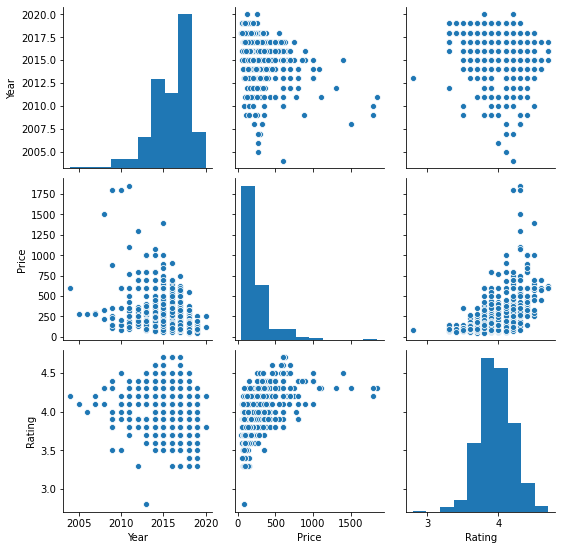

In [7]:
import seaborn as sb

sb.pairplot(dfClean)

In [8]:
dfClean.corr()

,Year,Price,Rating
Year,1.000000,-0.424948,-0.206095
Price,-0.424948,1.000000,0.539901
Rating,-0.206095,0.539901,1.000000


In [9]:
dfLarge = pd.read_csv('vinDataLarge.csv')
yearMask = dfLarge['Year'] < 2022
dfLargeClean = dfLarge[yearMask]

dfLargeClean.corr()

,Year,Price,Rating
Year,1.000000,-0.486648,-0.278772
Price,-0.486648,1.000000,0.597095
Rating,-0.278772,0.597095,1.000000


0.5399014967304493


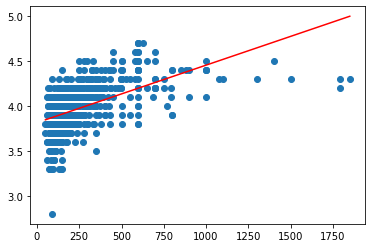

In [10]:
x = dfClean['Price']
y = dfClean['Rating']
plt.scatter(x, y)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
correlation = x.corr(y)
print(correlation)

0.5970954630350238


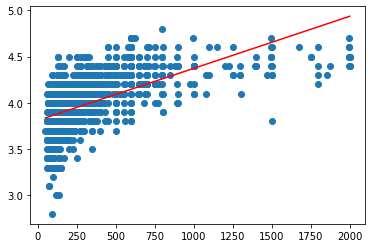

In [11]:
xL = dfLargeClean['Price']
yL = dfLargeClean['Rating']
plt.scatter(xL, yL)

plt.plot(np.unique(xL), np.poly1d(np.polyfit(xL, yL, 1))(np.unique(xL)), color='red')
correlation = xL.corr(yL)
print(correlation)

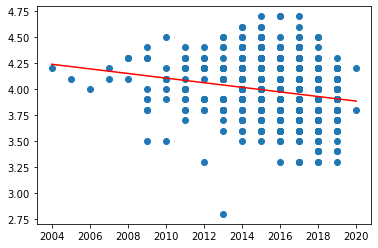

In [12]:
x = dfClean['Year']
y = dfClean['Rating']
plt.scatter(x, y)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

Vi kan se at desto større databasen er, desto stærkere er correlationen mellem pris og rating. Ville der være årsag til at scrape endnu mere?

In [13]:
for size in range(300, 1500, 200):
    print("Correlation ved størrelse " + str(size) + ": " + str(dfLargeClean['Year'][0:size].corr(dfLargeClean['Rating'][0:size])))

Correlation ved størrelse 300: -0.23401218516643876
Correlation ved størrelse 500: -0.23796757546493885
Correlation ved størrelse 700: -0.2173319349920702
Correlation ved størrelse 900: -0.25137713489329505
Correlation ved størrelse 1100: -0.2596959905033134
Correlation ved størrelse 1300: -0.2735288825678517


Videre undersøgning af hvor stærk correlationen er:

In [14]:
from sklearn.linear_model import LinearRegression
x = (dfLargeClean['Price'].values).reshape(-1,1)
y = (dfLargeClean['Rating'].values)
reg = LinearRegression().fit(x, y)

print(reg.score(x, y)); print(reg.coef_); print(reg.intercept_)

print(reg.predict([[1750]]))
print("Vi kan forvente at en vin til prisen 1750kr. har en rating på:"); print(0.00056345 * 1750 + 3.81)


0.3565229919770093
[0.00056345]
3.810086328166339
[4.79612752]
Vi kan forvente at en vin til prisen 1750kr. har en rating på:
4.7960375


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

dfTrain = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfTrain

print(dfTrain[60:75])
r2_score(dfTrain['Actual'], dfTrain['Predicted'])

    Actual  Predicted
60     3.7   3.841952
61     4.2   3.920889
62     3.6   3.848069
63     4.4   4.298499
64     4.5   4.919090
65     4.2   4.031578
66     3.9   3.864752
67     3.9   4.014895
68     3.8   3.851406
69     4.5   3.920361
70     3.7   3.903678
71     4.2   3.920889
72     4.3   4.087186
73     3.7   3.881435
74     4.3   3.934819


0.42309585785509307

## Hvilken type vin var mest populær det givne år?

In [55]:
dfLargeClean.head()

,Name,Year,Price,Rating,Country
1,Malbec 2018,2018,59.95,3.8,Argentina
2,Malbec 2016,2016,129.95,4.1,Argentina
3,Cabernet Sauvignon 2016,2016,750.00,4.6,United States
4,Malbec 2013,2013,99.95,3.9,Argentina
5,Red Blend 2017,2017,549.00,4.3,United States


In [56]:
data_chart = dfLargeClean.drop(columns='Price')
data_chart.head()

,Name,Year,Rating,Country
1,Malbec 2018,2018,3.8,Argentina
2,Malbec 2016,2016,4.1,Argentina
3,Cabernet Sauvignon 2016,2016,4.6,United States
4,Malbec 2013,2013,3.9,Argentina
5,Red Blend 2017,2017,4.3,United States


In [57]:
#Viser hvilken vin der var bedst for hvert år, samt hvilket land den kom fra. 
max_rating = data_chart.groupby('Year').max()
max = max_rating['Rating'].max()
min_rating = data_chart.groupby('Year').min()
#min_rating
max_rating
#max


,Name,Rating,Country
Year,,,
1982,Barolo Riserva 1982,4.6,Italy
1986,Cos d'Estournel 1986,4.4,France
1995,Saint-Julien (Grand Cru Classé) 1995,4.3,France
2003,Dominus (Christian Moueix) 2003,4.5,United States
2004,Saint-Julien (Grand Cru Classé) 2004,4.4,Lebanon
2005,Château d'Ampuis Côte-Rôtie 2005,4.4,France
2006,Martha's Vineyard Cabernet Sauvignon 2006,4.6,United States
2007,Viña Tondonia Reserva Blanco 2007,4.4,Spain
2008,Viña Tondonia Reserva 2008,4.3,Spain


In [58]:


newdf = max_rating.groupby('Name').max()
newdf

,Rating,Country
Name,,
Barolo Riserva 1982,4.6,Italy
Château d'Ampuis Côte-Rôtie 2005,4.4,France
Cos d'Estournel 1986,4.4,France
Dominus (Christian Moueix) 2003,4.5,United States
Martha's Vineyard Cabernet Sauvignon 2006,4.6,United States
Saint-Julien (Grand Cru Classé) 1995,4.3,France
Saint-Julien (Grand Cru Classé) 2004,4.4,Lebanon
Toscana Le Cupole Rosso 2010,4.6,United States
Vigneto di Popoli Montepulciano d'Abruzzo 2011,4.6,Spain


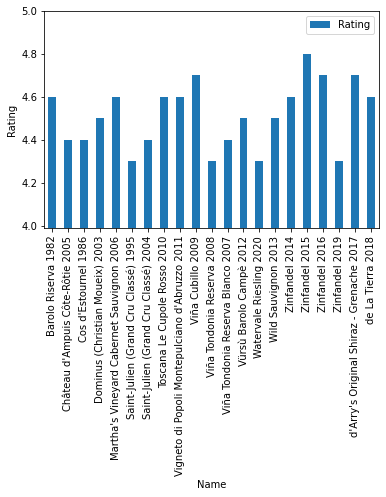

In [48]:
ax = newdf.plot.bar()
ax.set_ylim([3.99,5])
ax.set_ylabel('Rating')
ax

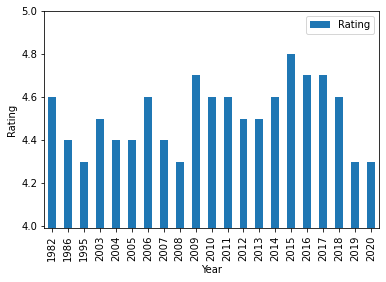

In [49]:
ax = max_rating.plot.bar()
ax.set_ylim([3.99,5])
ax.set_ylabel('Rating')
ax

In [59]:
#Hvilket land har haft den bedste vin flest gange.
no_of_occur_max = max_rating['Country'].value_counts()
no_of_occur_max

#Hvilket land har haft den dårligste vin flest gange.
#no_of_occur_min = min_rating['Country'].value_counts()
#no_of_occur_min


United States    7
Uruguay          5
Spain            4
France           3
Lebanon          1
Italy            1
Name: Country, dtype: int64